In [42]:
%matplotlib inline 
# import all the packages and functions needed
import numpy as np
# from sklearn.datasets import make_classification
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
import pandas as pd
from lid_driven_cavity_flow_pinn.utils import generate_csv_catalog, read_datafile, get_boundary_samples
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



## Generate the dataset

In this randomly generated dataset I decided to have just a tablular type output with 50,000 samples, 60 features (highly dimensional), and 25 being redundent information for the random and boosted trees.

In [26]:
# Generate the dataset with the number of samples and features with some being redundent and others being useful information
# Input, Response = make_classification(n_samples=50000, n_features=35+25, n_informative=35, n_redundant=25, random_state=7406)

catalog = generate_csv_catalog()

catalog

                        filepath   Re  xsize  ysize
1879      ../data/Re300/PUV0.txt  300    151    151
1880    ../data/Re300/PUV100.txt  300    151    151
1881   ../data/Re300/PUV1000.txt  300    151    151
1882  ../data/Re300/PUV10000.txt  300    151    151
1883  ../data/Re300/PUV10100.txt  300    151    151 
 number of files cataloged: 4850



,filepath,Re,xsize,ysize
1879,../data/Re300/PUV0.txt,300,151,151
1880,../data/Re300/PUV100.txt,300,151,151
1881,../data/Re300/PUV1000.txt,300,151,151
1882,../data/Re300/PUV10000.txt,300,151,151
1883,../data/Re300/PUV10100.txt,300,151,151
...,...,...,...,...
1874,../data/Re2000/PUV9500.txt,2000,151,151
1875,../data/Re2000/PUV9600.txt,2000,151,151
1876,../data/Re2000/PUV9700.txt,2000,151,151
1877,../data/Re2000/PUV9800.txt,2000,151,151


In [27]:
# pull out a single file and check it out.
P, U, V, time, Re = read_datafile(catalog.iloc[1800]["filepath"])
print("total data points in a single file", P.flatten().shape[0] + U.flatten().shape[0] + V.flatten().shape[0])



total data points in a single file 68403


In [28]:
get_boundary_samples(P).shape[0] / P.flatten().shape[0] * 100



2.6314635323012148

In [36]:
# computational boundary
x_lower, x_upper, y_lower, y_upper = 0, 1, -1, 0

# make a new dataframe with all the data in it
P_list, U_list, V_list, time_list, Re_list = [], [], [], [], []
P_boundary_list, U_boundary_list, V_boundary_list = [], [], []
catalog_dict = catalog.to_dict("records")
for file in tqdm(catalog_dict):
    P, U, V, time, Re = read_datafile(file["filepath"])
    
    # stash all of them
    P_list.append(P.flatten())
    U_list.append(U.flatten())
    V_list.append(V.flatten())
    # select just the boundary points
    P_boundary_list.append(get_boundary_samples(P))
    U_boundary_list.append(get_boundary_samples(U))
    V_boundary_list.append(get_boundary_samples(V))
    # don't forget the time and response variable
    time_list.append(time.flatten()[0])
    Re_list.append(Re)
    
P_df = pd.DataFrame(P_list)
U_df = pd.DataFrame(U_list)
V_df = pd.DataFrame(V_list)
P_boundary_df = pd.DataFrame(P_boundary_list)
U_boundary_df = pd.DataFrame(U_boundary_list)
V_boundary_df = pd.DataFrame(V_boundary_list)
time_df = pd.DataFrame(time_list)
Re_df = pd.DataFrame(Re_list)


# put together the whole array
P_df_al = pd.concat([P_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)
U_df_al = pd.concat([U_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)
V_df_al = pd.concat([V_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)

# put together just the boundary list
P_boundary_df_al = pd.concat([P_boundary_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)
U_boundary_df_al = pd.concat([U_boundary_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)
V_boundary_df_al = pd.concat([V_boundary_df, pd.DataFrame(time_list), pd.DataFrame(Re_list)], axis=1)


# do some relabeling
P_df_al.columns = [*P_df_al.columns[:-2], 'Time', 'Re']
U_df_al.columns = [*U_df_al.columns[:-2], 'Time', 'Re']
V_df_al.columns = [*V_df_al.columns[:-2], 'Time', 'Re']

P_df_al.columns = [*P_df_al.columns[:-2], 'Time', 'Re']
U_df_al.columns = [*U_df_al.columns[:-2], 'Time', 'Re']
V_df_al.columns = [*V_df_al.columns[:-2], 'Time', 'Re']
    

  0%|          | 0/4850 [00:00<?, ?it/s]

In [93]:
V_df_al_arr = U_df_al.iloc[:,:-2].to_numpy()
norm_pres = V_df_al_arr/np.linalg.norm(V_df_al_arr)

Text(0.5, 0, 'flattened U velocity')

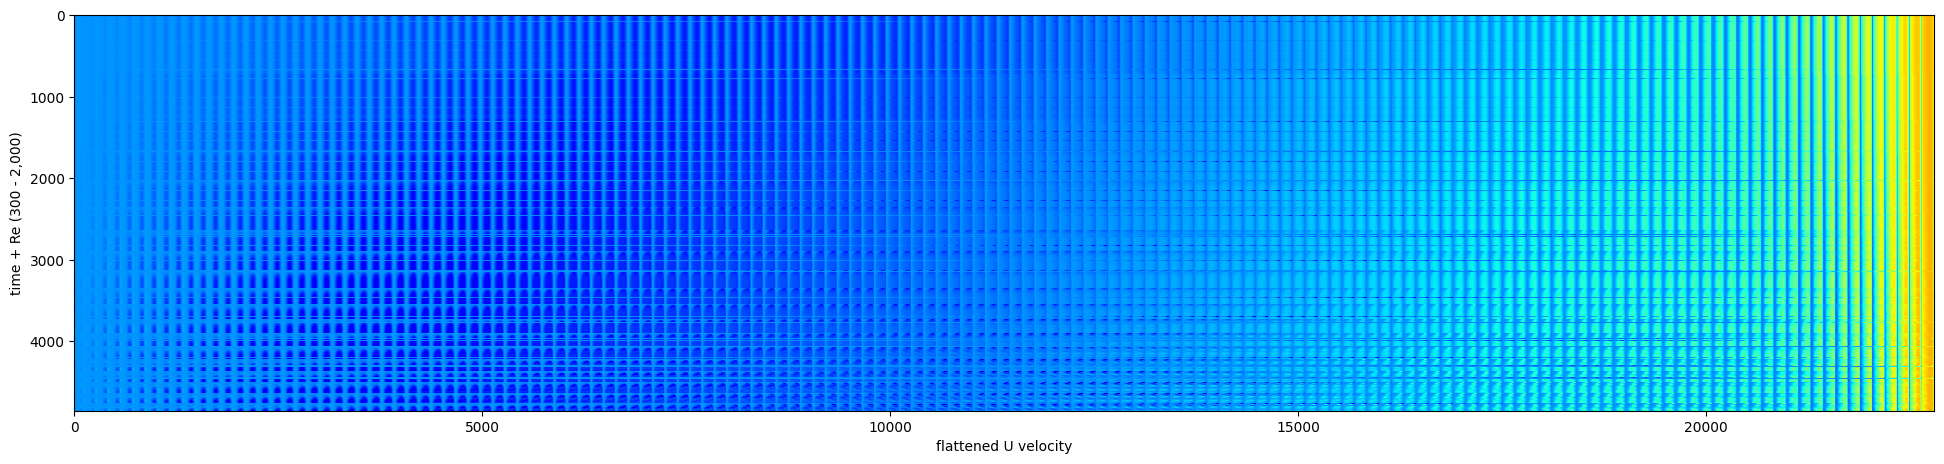

In [97]:
fig, ax = plt.subplots(1, figsize=(24,24))
im = ax.imshow(V_df_al_arr, cmap="jet",interpolation='nearest')
plt.ylabel("time + Re (300 - 2,000)")
plt.xlabel("flattened U velocity")

In [ ]:
plt.imshow(np.array(P_list))

From the output above it's worth noting the dataset is binary! (either 0 or 1)

Now let's split this into a test and train split, and do stratified cross-validation on the training dataset!

In [22]:
Input_train, Input_test, Response_train, Response_test = train_test_split(Input, Response, test_size=0.25, random_state=42) # 42, the meaning of life???

# Random Forest Classifier

Alrighty, now that the test and train data is split, let's train some models!

In [23]:
# define the model
RandomForestModel = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7406)
n_scores = cross_val_score(RandomForestModel, Input_train, Response_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# no cv (for later use on the test set)
RandomForestModel_nocv = RandomForestClassifier().fit(Input_train, Response_train)

Accuracy: 0.956 (0.003)


Hey! 95.6% accuracy, that's not bad at all! 


# Gradient Boosting Classifier

Now let's check out the same thing but for an `sklearn` boosting model such as the Gradient Boosting Classifier

In [27]:
GradBoostingClassModel = GradientBoostingClassifier(max_depth=1, random_state=7406)

n_scores_gbcm = cross_val_score(GradBoostingClassModel, Input_train, Response_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores_gbcm), std(n_scores_gbcm)))
GradBoostingClassModel_nocv = GradientBoostingClassifier(random_state=7406).fit(Input_train, Response_train)

Accuracy: 0.832 (0.004)


Ok! 83.2% accuracy, not too bad, but certainly below the Random forest. But hold on a second, the learning rate and max depth were just randomly selected, let's play around with that a bit.

In [25]:
best_list = []

for step in np.linspace(0.001, 2, 5):
    
    GradBoostingClassModel = GradientBoostingClassifier(max_depth=1, random_state=7406)

    n_scores_gbcm = cross_val_score(GradBoostingClassModel, Input_train, Response_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores_gbcm), std(n_scores_gbcm)))
    best_list.append([step, mean(n_scores_gbcm), std(n_scores_gbcm)])
    


Accuracy: 0.832 (0.004)
Accuracy: 0.832 (0.004)
Accuracy: 0.832 (0.004)
Accuracy: 0.832 (0.004)
Accuracy: 0.832 (0.004)


In [26]:
print(max([sublist[1] for sublist in best_list]))

0.8321422222222222


Alright, so we sufficiently explored the Boosting model, and the default Random Forest Classifier doesn't do too bad of a job, let's check out a "traditional method" like KNN or Logistic Regression

# Logistic Regression

In [28]:
logreg = LogisticRegression(C=1e5)

n_scores = cross_val_score(logreg, Input_train, Response_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
logreg_nocv = LogisticRegression(C=1e5).fit(Input_train, Response_train)

Accuracy: 0.856 (0.005)


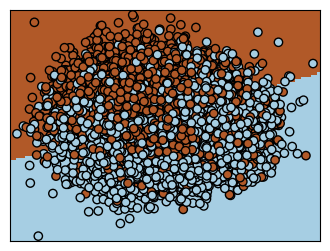

In [29]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.inspection import DecisionBoundaryDisplay

# import some data to play with
X = Input_train[:,:2] # take the rist 2 features
Y = Response_train

# Create an instance of Logistic Regression Classifier and fit the data.
logreg = LogisticRegression(C=1e5)
logreg.fit(X, Y)

_, ax = plt.subplots(figsize=(4, 3))
DecisionBoundaryDisplay.from_estimator(
    logreg,
    X,
    cmap=plt.cm.Paired,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    eps=0.5,
)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors="k", cmap=plt.cm.Paired)


plt.xticks(())
plt.yticks(())

plt.show()

Well, this is randomly generated data, so I guess this makes sense the plot isn't very useful, also keeping in mind there are 60 factors at play here, and viewing things in the 60th dimension isn't really encouraged yet!


Finally, let's check out the test accuracy for all the trained models:

In [30]:
print('the Random Forest test accuracy:', (RandomForestModel_nocv.score(Input_test, Response_test))) 
print('the Gradient Boosting test accuracy:', (GradBoostingClassModel_nocv.score(Input_test, Response_test))) 
print('the Logistic Regression test accuracy:', (logreg_nocv.score(Input_test, Response_test))) 

the Random Forest test accuracy: 0.95832
the Gradient Boosting test accuracy: 0.92264
the Logistic Regression test accuracy: 0.85632


Checking to make sure I answered the prompt:

1) Be sure to fit both random forests and boosting on a training set and to evaluate their
performance on a test set. 

See the Random Forest and Gradient Boosting training set.

2) How accurate are the results compared to simple baseline methods? For instance, some
candidate baseline methods can be KNN, linear regression, LDA, logistic regression, local
smoothing, tree, etc., whichever are appropriate.

See the Logistic Regression Section

3) Which of these approaches yields the best performance in term of smallest testing error?

    See the section right above this! The `Random Forest` model overall did the best with a highly dimensional, noisy factor binary classifictation problem

4) You need to explain how or why you choose certain tuning parameters in these approaches,
based only on the training set. This can be done through either cross-validation of the training
set, or variable selection such as AIC or BIC from the training set, or any other reasonable
approaches.

Overall the tuning parameters I chose usually were a default, or I would iterate randomly (random walk)
through a few larger or smaller choices. For the case of the Boosting model I did an exhaustive search of the learning rate 
to see if that effected the outcome and it did not.

5) In your writeup, please follow the guideline of final course project. In particular, please provide
necessary background on the data set of your choice, so that readers can understand your
data set and analysis.

Please see the other pdf document, I would love feedback even though the final results aren't done cooking yet.

I know I chose a pretty boring dataset, but this had 2 benefits:

     1) it allowed me to analyze models without getting tied up in data ETL, cleaning etc.
     2) This allowed me to work more on the project, please feel free to give any feedback, 
        as I plan on implementing a few of the algorithms here (functioned as a simple test bench)
